In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import erf
import numericalunits as nu
from scipy.integrate import quad

In [2]:
# def Inf(func,xmin,xmax,n):
#     bins=np.linspace(xmin,xmax,n+1)
#     center=(bins[1:]+bins[:-1])/2
#     width=(xmax-xmin)/n
#     values=[func(i) for i in center]
#     return np.sum(values)*width

In [14]:
def Inelastic_Scatter(m_x=1e9, #keV/c^2
                      delta=0, #keV
                      rho=0.3*1e6, #keV/c^2/cm^3
                      sigma_0=1e-40, #cm^2
                      v_0=220, #km/s
                      v_e=232, #km/s
                      v_esc=533, #km/s
                      form_factors=2,
                      A=132,
                      ER_min=0,  #keV
                      ER_max=600, #keV
                      bins_number=10000
                     ):
    #set units on quantities:
    m_x=m_x * nu.keV / nu.c0 ** 2 
    delta=delta * nu.keV
    rho=rho * nu.keV / nu.c0 ** 2 / nu.cm**3
    sigma_0=sigma_0 * nu.cm ** 2
    v_0=v_0* nu.km /nu.s
    v_e=v_e* nu.km /nu.s
    v_esc=v_esc* nu.km /nu.s
    ER_min=ER_min* nu.keV
    ER_max=ER_max* nu.keV

    #some useful quanties:
    m_N=A* nu.amu #mass of nucleus
    mu_N=m_x*m_N/(m_x+m_N)  #reduced mass of DM and nucleus
    mu_n=m_x*nu.amu/(m_x+nu.amu)  #reduced mass of DM and nucleon
    
    #create energy range array
    _E_R=np.linspace(ER_min,ER_max,bins_number)
    E_R=_E_R[1:]
    
    #calculation of sigma
    sigma=sigma_0*A**2*mu_N**2/mu_n**2    #setting fp=fn
    
    #calculation of the Form Factor:
    if form_factors==1:  #using Helm's
        q = np.sqrt(2*m_N*E_R)   # momentum transfer in keV/c
        _q=q / (nu.MeV / nu.c0) /197.326
        a = 0.52;
        s = 0.9;
        c = 1.23*pow(A,(1./3.))-0.60;
        r_n = np.sqrt(c*c+7/3.*np.pi*np.pi*a*a-5*s*s);
        FF_SI = 3*np.exp(-(_q*s*_q*s)/2.)*(np.sin(_q*r_n)-_q*r_n*np.cos(_q*r_n))/((_q*r_n)**3.0);
        Fv2=pow(FF_SI,2.0)
    else :   #using the factor from Ref[1]
        #para_set
        c1=-132.841
        c2=38.4859
        c3=-4.08455
        c4=0.153298
        c5=-0.0013897
        
        #calculation
        b2=1/nu.amu/nu.c0**2/(45*A**(-1/3)-25*A**(-2/3))/nu.MeV
        q=np.sqrt(2*E_R*m_N) * nu.c0
        u=q**2*b2/2
        Fv2=np.exp(-u)/A**2*pow(A+c1*u+c2*u**2+c3*u**3+c4*u**4+c5*u**5,2)
    
    #calculation of the integration
    
    v_min=[1/np.sqrt(2*E_R[i]*m_N)*(delta+E_R[i]*m_N/mu_N) for i in range(len(E_R))]
    #print([v_min[i]*(nu.s/nu.km) for i in range(len(E_R))])

    I=np.zeros_like(E_R)
    
    for i in range(len(E_R)):
        if v_min[i]<(v_esc-v_e) :
            I[i]=0.5*np.sqrt(np.pi)*v_0*(erf((v_min[i]+v_e)/v_0)-erf((v_min[i]-v_e)/v_0))-2*v_e*np.exp(-v_esc**2/v_0**2)
        elif v_min[i]<(v_esc+v_e) :
            I[i]=0.5*np.sqrt(np.pi)*v_0*(erf(v_esc/v_0)-erf((v_min[i]-v_e)/v_0))-(v_esc+v_e-v_min[i])*np.exp(-v_esc**2/v_0**2)
        else:
            I[i]=0
            

    
    #other muliplier
    k=erf(v_esc/v_0)-2/np.sqrt(np.pi)*v_esc/v_0*np.exp(-v_esc**2/v_0**2)
    factor=rho/(m_x*mu_N**2*k*np.sqrt(np.pi)*v_0*v_e)
    
    result=factor*Fv2*sigma*I*(nu.keV*nu.day*nu.kg)
    
    
    return result
   


In [12]:
list1=Inelastic_Scatter(delta=0,form_factors=2,m_x=1e9)
list2=Inelastic_Scatter(delta=100,form_factors=2,m_x=1e9)
list3=Inelastic_Scatter(delta=200,form_factors=2,m_x=1e9)
list4=Inelastic_Scatter(delta=300,form_factors=2,m_x=1e9)

In [ ]:
import pandas as pd

delta_0=pd.read_csv('./data/delta_0.csv',header=None)
delta_100=pd.read_csv('./data/delta_100.csv',header=None)
delta_200=pd.read_csv('./data/delta_200.csv',header=None)
delta_300=pd.read_csv('./data/delta_300.csv',header=None)

delta_0=delta_0.sort_values(by=0)
delta_100=delta_100.sort_values(by=0)
delta_200=delta_200.sort_values(by=0)
delta_300=delta_300.sort_values(by=0)

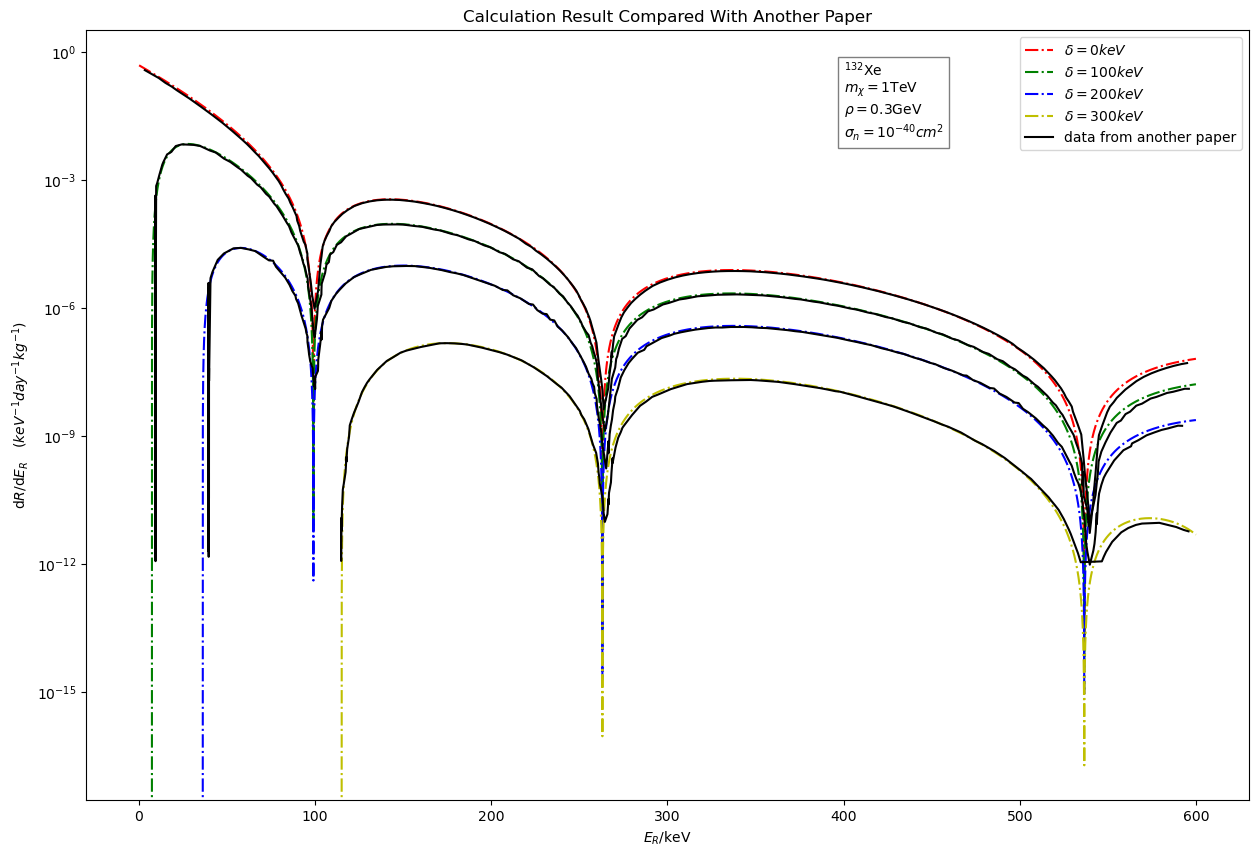

In [42]:
fig=plt.figure(figsize=(15,10))
plt.yscale('log')
xaxis=np.linspace(0,600,10000)
plt.plot(xaxis[1:],list1,color='r',linestyle='-.',label='$\\delta=0keV$')
plt.plot(xaxis[1:],list2,color='g',linestyle='-.',label='$\\delta=100keV$')
plt.plot(xaxis[1:],list3,color='b',linestyle='-.',label='$\\delta=200keV$')
plt.plot(xaxis[1:],list4,color='y',linestyle='-.',label='$\\delta=300keV$')


plt.plot(delta_0[0],delta_0[1],color='black',label='data from another paper')
plt.plot(delta_100[0],delta_100[1],color='black')
plt.plot(delta_200[0],delta_200[1],color='black')
plt.plot(delta_300[0],delta_300[1],color='black')

plt.title('Calculation Result Compared With Another Paper')
plt.xlabel('$E_R$/keV')
plt.ylabel('$\\mathrm{d}R/\\mathrm{d}E_R  \\ \\ \\ (keV^{-1} day^{-1} kg^{-1})$')
plt.legend()
plt.text(400,1e-2,'$^{132}$Xe\n$m_\\chi=1$TeV\n$\\rho=0.3$GeV\n$\\sigma_n=10^{-40}cm^2$',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 4})

plt.savefig('./plot/idm_cal_result1.png',dpi=400)
plt.show()